In [1]:
# Initial imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from pathlib import Path
import requests

%matplotlib inline

In [2]:
XAR_csv = Path("ASD_Data/XAR_DATA.csv")

In [3]:
XAR_df = pd.read_csv(XAR_csv, index_col='Date', infer_datetime_format=True, parse_dates=True)

In [4]:
XAR_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-10-03,24.850000,24.850000,24.850000,24.850000,21.693798,0
2011-10-04,23.480000,24.415001,23.480000,24.415001,21.314049,23000
2011-10-05,24.735001,24.754999,24.549999,24.754999,21.610859,21200
2011-10-06,24.969999,25.260000,24.969999,25.260000,22.051729,55800
2011-10-07,25.690001,25.690001,25.280001,25.320000,22.104103,30600


In [5]:
XAR_df.sort_index(ascending=True, inplace=True)

In [6]:
XAR_df = XAR_df.rename(columns={'Close': 'Close'})
XAR_df = XAR_df[['Close']]
XAR_df

,Close
Date,
2011-10-03,24.850000
2011-10-04,24.415001
2011-10-05,24.754999
2011-10-06,25.260000
2011-10-07,25.320000
...,...
2021-06-24,133.850006
2021-06-25,136.440002
2021-06-28,134.210007


In [7]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window-1):
        features = df.iloc[i : (i+window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [9]:
window_size = 100
feature_column = 0
target_column = 0

X, y = window_data(XAR_df, window_size, feature_column, target_column)

print(f"X sample values:\n{X[:3]} \n")
print(f"y sample values:\n{y[:3]}")

X sample values:
[[24.85     24.415001 24.754999 25.26     25.32     25.32     25.32
  25.32     25.32     25.32     25.91     26.41     26.129999 26.129999
  26.129999 26.129999 27.379999 27.120001 28.105    28.030001 27.85
  26.309999 26.905001 27.725    27.67     27.790001 27.965    27.18
  27.205    27.790001 27.780001 27.780001 27.59     26.945    26.945
  26.35     26.344999 25.719999 25.719999 26.41     26.504999 27.51
  27.705    27.594999 27.594999 27.594999 27.594999 26.764999 26.764999
  26.764999 27.155001 26.51     26.51     26.915001 26.915001 27.475
  27.58     28.       28.055    28.055    28.055    27.995001 27.995001
  28.245001 28.245001 27.799999 27.799999 27.799999 27.799999 28.975
  29.115    28.76     28.959999 29.139999 29.51     29.42     29.334999
  29.334999 29.629999 29.465    29.465    29.125    29.290001 30.065001
  29.969999 30.475    30.4      30.504999 30.66     30.775    30.58
  30.889999 30.575001 30.434999 30.76     30.76     30.76     30.674999
  30

In [10]:
split = int(0.6 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [11]:
y_train

array([[30.805   ],
       [30.575001],
       [30.73    ],
       ...,
       [79.720001],
       [79.800003],
       [81.089996]])

In [12]:
# Import MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

x_train_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()

x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

X_test = x_train_scaler.transform(X_test)
y_test = y_train_scaler.transform(y_test)

In [13]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [15]:
model = Sequential()

number_units = window_size
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(units = number_units, return_sequences = True, input_shape= (X_train.shape[1], 1)))
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units = number_units, return_sequences = True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units = number_units))
model.add(Dropout(dropout_fraction))

# Output Layer
model.add(Dense(1))

In [16]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 100)          40800     
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [17]:
model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=100, verbose=1)

Epoch 1/20
15/15 [==============================] - 10s 311ms/step - loss: 0.0102
Epoch 2/20
15/15 [==============================] - 5s 365ms/step - loss: 0.0081
Epoch 3/20
15/15 [==============================] - 6s 354ms/step - loss: 0.0123
Epoch 4/20
15/15 [==============================] - 5s 327ms/step - loss: 0.0049
Epoch 5/20
15/15 [==============================] - 5s 353ms/step - loss: 0.0176
Epoch 6/20
15/15 [==============================] - 5s 340ms/step - loss: 0.0503
Epoch 7/20
15/15 [==============================] - 7s 476ms/step - loss: 0.0694
Epoch 8/20
15/15 [==============================] - 10s 645ms/step - loss: 0.0322
Epoch 9/20
15/15 [==============================] - 14s 965ms/step - loss: 0.0069
Epoch 10/20
15/15 [==============================] - 12s 803ms/step - loss: 0.0036
Epoch 11/20
15/15 [==============================] - 13s 854ms/step - loss: 0.0046
Epoch 12/20
15/15 [==============================] - 12s 816ms/step - loss: 0.0018
Epoch 13/20
15/15 [

In [18]:
model.evaluate(X_test, y_test, verbose=0)

0.008289593271911144

In [19]:
predicted = model.predict(X_test)

In [20]:
predicted_prices = y_train_scaler.inverse_transform(predicted)

In [21]:
real_prices = y_train_scaler.inverse_transform(y_test.reshape(-1,1))

In [22]:
XAR_actual_predicted = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = XAR_df.index[-len(real_prices): ])

XAR_actual_predicted.head()

,Actual,Predicted
Date,,
2017-10-04,81.099998,78.560959
2017-10-05,81.449997,78.913551
2017-10-06,81.919998,79.264542
2017-10-09,81.970001,79.618462
2017-10-10,82.209999,79.968201


In [23]:
XAR_actual_predicted.tail()

,Actual,Predicted
Date,,
2021-06-24,132.559998,123.837517
2021-06-25,133.850006,123.882217
2021-06-28,136.440002,123.940125
2021-06-29,134.210007,124.047287
2021-06-30,132.119995,124.166008


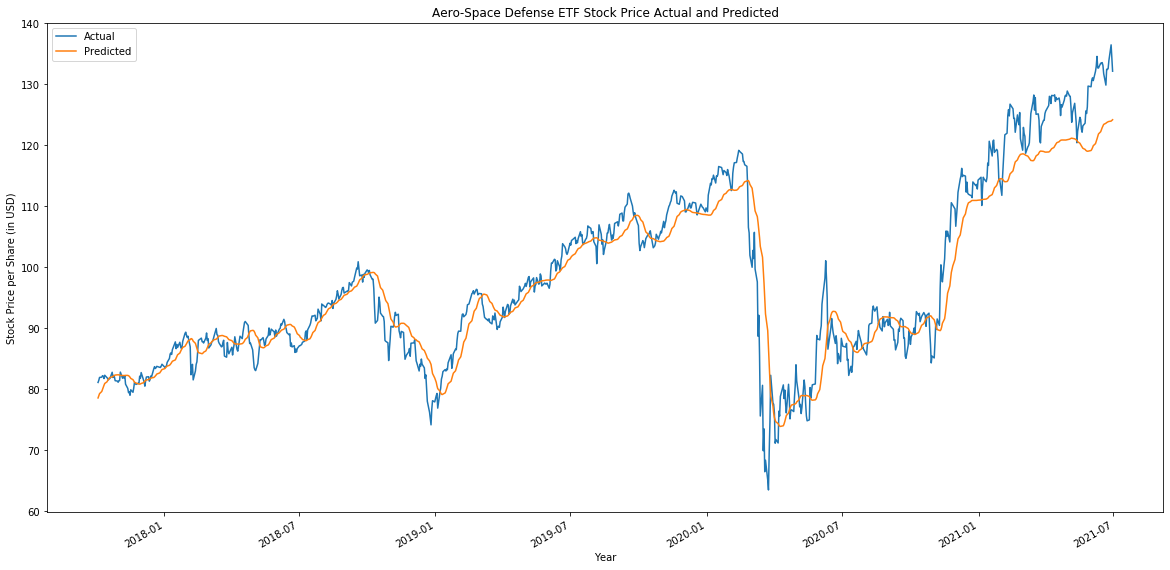

In [31]:
XAR_actual_predicted.plot(figsize=(20,10))
#plt.plot(BA_actual_predicted['Actual'], label='Boeing_Actual')
#plt.plot(BA_actual_predicted['Predicted'], label='Boeing_Predictions')
plt.title('Aero-Space Defense ETF Stock Price Actual and Predicted')
plt.xlabel('Year')
plt.ylabel('Stock Price per Share (in USD)')
plt.legend(loc='best')
plt.show()

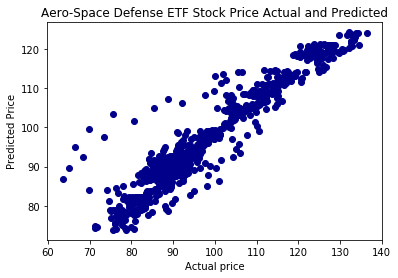

In [28]:
plt.scatter(XAR_actual_predicted['Actual'], XAR_actual_predicted['Predicted'], color= 'Darkblue')
plt.title('Aero-Space Defense ETF Stock Price Actual and Predicted')
plt.xlabel('Actual price')
plt.ylabel('Predicted Price')
plt.show()

In [29]:
XAR_actual_predicted.describe()

,Actual,Predicted
count,941.000000,941.000000
mean,97.692965,96.637688
std,14.687080,12.420221
min,63.480000,73.892342
25%,87.129997,87.740562
50%,92.800003,92.758545
75%,107.739998,106.261208
max,136.440002,124.166008


In [32]:
x2 = XAR_actual_predicted['Actual'].mean()
y2 = XAR_actual_predicted['Predicted'].mean()
Accuracy = x2/y2*100
print('The accuracy of the model is', Accuracy)

The accuracy of the model is 101.09199347686607


In [41]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(XAR_actual_predicted['Actual'], XAR_actual_predicted['Predicted']))
print(rmse)

4.867383541701208
